In [7]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
skimage: 0.14dev


In [39]:
def numberprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    seed = np.copy(gray)
    seed[1:-1, 1:-1] = gray.max()
    mask = gray

    filled = reconstruction(seed, mask, method='erosion')
    holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    niblack = holes > threshold_niblack(holes, window_size=71, k=0.9)

    return remove_small_holes(img_as_ubyte(niblack), 500)

def serialprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    holes = denoise_tv_chambolle(rank.enhance_contrast(gray, disk(8)), weight=0.3)
    niblack = holes > threshold_niblack(holes, window_size=61, k=0.9)

    return remove_small_holes(img_as_ubyte(niblack), 400)

def segmentation(src, filename, current_file_index, ax):
      
    rotated = src.rotate(-90, expand=True)
    number = rotated.crop((1276, 78, 1276+392, 78+1166))
    
    ax[current_file_index*4].imshow(number)
    ax[current_file_index*4].set_title('Original image: ' + filename)
    ax[current_file_index*4].axis('off')
    
    number_width = number.size[0]
    number_height = number.size[1]
    number = number.resize(((int)(number_width * 900 / number_height), 900), Image.ANTIALIAS)
    
    %time filtered_number = numberprepare(number)
    
    serial = rotated.crop((1276, 2088, 1276+292, 2088+448))
    
    ax[current_file_index*4 + 1].imshow(serial)
    ax[current_file_index*4 + 1].set_title('Original image: ' + filename)
    ax[current_file_index*4 + 1].axis('off')

    %time filtered_serial = serialprepare(serial)

    ax[current_file_index*4 + 2].imshow(filtered_serial, cmap='gray')
    ax[current_file_index*4 + 2].set_title('Serial')
    ax[current_file_index*4 + 3].axis('off')
       
    ax[current_file_index*4 + 3].imshow(filtered_number, cmap='gray')
    ax[current_file_index*4 + 3].set_title('Number')
    ax[current_file_index*4 + 3].axis('off')

  0%|          | 0/74 [00:00<?, ?it/s]/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
100%|██████████| 74/74 [01:16<00:00,  1.02s/it]


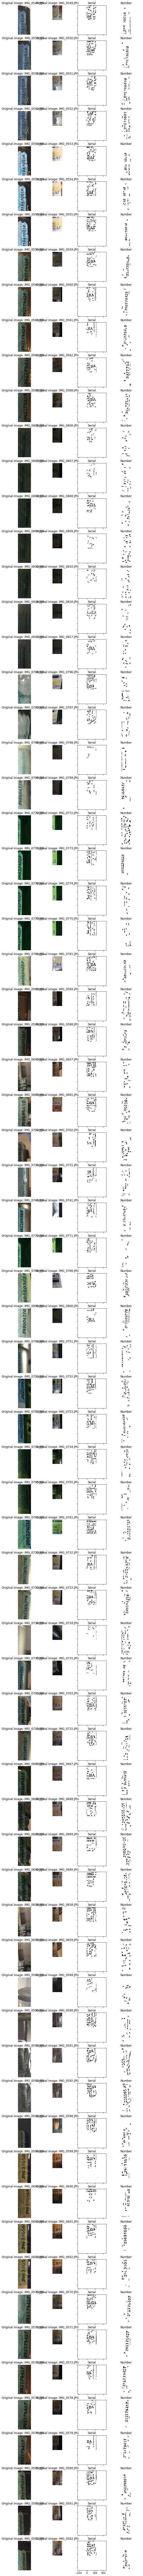

In [38]:
DIR = 'test_data/premasked'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0
fig, ax = plt.subplots(filescount, 4, figsize=(10, 200), sharex=True, sharey=True)
ax = ax.ravel()

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = Image.open(os.path.join(DIR, filename))
    segmentation(file_src, filename, current_file_index, ax)
    current_file_index += 1
    
plt.show()